In [18]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
# import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap
    

In [20]:
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/'
train_x_df = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainX.csv")
train_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainY.csv")
test_x_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testX.csv")
test_y_df= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testY.csv")
train_x = torch.from_numpy(train_x_df.to_numpy())
train_y = torch.from_numpy(train_y_df.to_numpy().reshape(-1))
test_x = torch.from_numpy(test_x_df.to_numpy())
test_y = torch.from_numpy(test_y_df.to_numpy().reshape(-1))


In [21]:
# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_x = scaling.transform(train_x_df)
test_x = scaling.transform(test_x_df) 

train_y = train_y_df.to_numpy().flatten()
test_y = test_y_df.to_numpy().flatten()


In [22]:
def rf_results(model, train_x, train_y, test_x, test_y): 
    """Make predictions adn get probabilities
    @params
    model: fitted model (fitted to train set)
    train_x, train_y, test_x, test_y: train and test set inputs (np arrays)
    @returns
    train/test predictions
    train/test accuracies 
    train/test probabilities"""
    train_pred = model.predict(train_x) 
    test_pred = model.predict(test_x)
    train_acc = accuracy_score(train_y, train_pred) 
    test_acc = accuracy_score(test_y, test_pred) 
    print(f'train accuracy: {train_acc}')
    print(f'test accuracy: {test_acc}')
    train_prob = model.predict_proba(train_x) 
    test_prob = model.predict_proba(test_x) 
    return train_pred, test_pred, train_acc, test_acc, train_prob, test_prob

In [23]:
def rf_models(train_x, train_y, test_x, test_y, rf_type, parameters, dataset_type):
    """Fit a RF model, make predictions, get probabilities
    @params: 
    train_x, train_y, test_x, test_y: train and test set inputs (np arrays) 
    rf_type: model type: RandomForestClassifier, RandomForestClassifier with class_weight:'balanced', or BalancedRandomForestClassifier
        default is RFC 
    parameters: dict for model params 
    dataset_type: binding or inhibition
    @returns: dict with model, train/test prections and probabilities
    """
    n_estimators = parameters.get('n_estimators', 100)
    random_state = parameters.get('random_state', 42) 
    criterion = parameters.get('criterion', 'gini')
    max_depth = parameters.get('max_depth', 100)
    min_samples_split = parameters.get('min_samples_split', 2) 
    min_samples_leaf = parameters.get('min_samples_leaf', 1) 
    bootstrap = parameters.get('bootstrap', False) 
    max_features = parameters.get('max_features', None) 
    class_weight = parameters.get('class_weight', None)
    
    if (rf_type == 'balanced class_weight'): 
        model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight='balanced')
    elif (rf_type == 'balanced RF'):
        model = BalancedRandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight=class_weight)
    else:
        model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight=class_weight)
        
    model.fit(train_x, train_y)
    train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(model, train_x, train_y, test_x, test_y)
    classes = ['0','1']
    plot_confusion_matrix(train_y, train_pred, classes, title=f"NEK2 {dataset_type} Train: {rf_type}")
    plot_confusion_matrix(test_y, test_pred, classes, title=f"NEK2 {dataset_type} Test: {rf_type}")
    
    return {'model': model, 'train_pred':train_pred, 'test_pred': test_pred, 'train_prob':train_prob, 'test_prob': test_prob}

In [24]:
@timing
def find_best_models(train_x, train_y, test_x, test_y, rf_type, parameters, param_dist, dataset_type, verbose_val=None):
    """uses GridSearchCV not random grid search
    Grid search to find the best model, make predictions (train and test), get probability (train and test), and plot CM 
    Save best model to pickle file 
    @params:
    train_x, train_y, test_x, test_y: train and test set inputs (np arrays) 
    rf_type: model type: RandomForestClassifier, RandomForestClassifier with class_weight:'balanced', or BalancedRandomForestClassifier
        default is RFC 
    parameters: dict for model params 
    param_dist: parameters for grid search
    dataset_type: binding or inhibition
    @returns: dict with model, train/test prections and probabilities
    """
    n_estimators = parameters.get('n_estimators', 100)
    random_state = parameters.get('random_state', 42) 
    criterion = parameters.get('criterion', 'gini')
    max_depth = parameters.get('max_depth', 100)
    min_samples_split = parameters.get('min_samples_split', 2) 
    min_samples_leaf = parameters.get('min_samples_leaf', 1) 
    bootstrap = parameters.get('bootstrap', False) 
    max_features = parameters.get('max_features', None) 
    class_weight = parameters.get('class_weight', None)
    bootstrap = parameters.get('bootstrap', False)
    if (verbose_val==None): 
        verbose_val = 0
    if (rf_type == 'balanced class_weight'): 
        model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight='balanced')
    elif (rf_type == 'balanced RF'):
        model = BalancedRandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features)
    else:
        model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split
                                , min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, max_features=max_features, class_weight=class_weight)

    rand_search = GridSearchCV(estimator =model, param_grid = param_dist,cv=5, n_jobs=8, verbose=verbose_val)
    rand_search.fit(train_x, train_y) 
    best_rf = rand_search.best_estimator_
    
    return {'best_model': best_rf, 'train_pred':train_pred, 'test_pred': test_pred, 'train_prob':train_prob, 'test_prob': test_prob}
    

train accuracy: 1.0
test accuracy: 0.9081272084805654


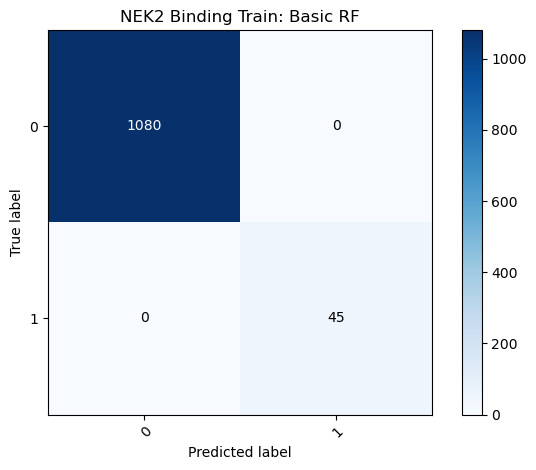

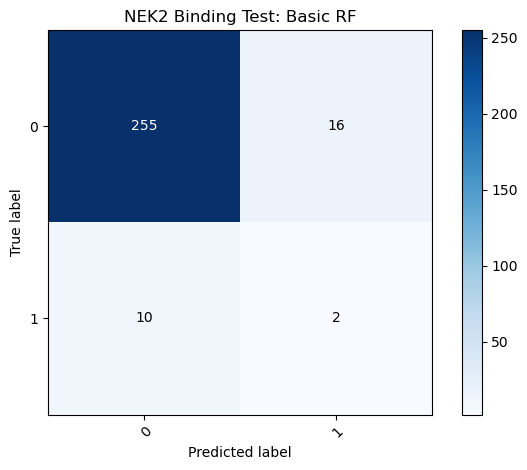

In [25]:
result1 = rf_models(train_x, train_y, test_x, test_y, 'Basic RF', {}, 'Binding')


In [26]:
param_grid = {
    'n_estimators': np.linspace(100, 2000, 5, dtype = int),
    'max_depth': [20, 40, 60, 80, 100, 150, 200, 220],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4, 5],
    'criterion': ['gini','entropy']
}

In [16]:

result1_best = find_best_models(train_x, train_y, test_x, test_y, 'Basic RF', {}, 
                                param_grid, 'Binding', verbose_val=2)
# result1_best = find_best_models(train_x, train_y, test_x, test_y, 'Basic RF', {'bootstrap':True, 'class_weight':'balanced'}, 
#                                 param_grid, 'Binding', 'NEK2bind_gridsearch_basic_best', verbose_val=2)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=575; total time= 1.7min
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=1525; total time= 6.0min
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 9.9min
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=3, n_estimators=1525; total time= 6.9min
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  30.1s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=  22.6s
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=575; total time= 2.9min
[CV] END criterion=gini, max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=575; total time= 2.3m

NameError: name 'train_pred' is not defined

In [ ]:
best_params = result1_best['best_model'].get_params()
    for param, value in best_params.items():
        print(f"{param}: {value}")
    train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(result1_best['best_model'], train_x, train_y, test_x, test_y)
    classes = ['0','1']
    plot_confusion_matrix(train_y, train_pred, classes, title=f"Best NEK2 Binding Train: Basic RF")
    plot_confusion_matrix(test_y, test_pred, classes, title=f"Best NEK2 Binding Test: Basic RF")
    pklfile = 'NEK2bind_gridsearch_basic_best.pkl'
    with open(pklfile, 'wb') as f:
        pickle.dump(result1_best['best_model'], f)

train accuracy: 1.0
test accuracy: 0.9363957597173145


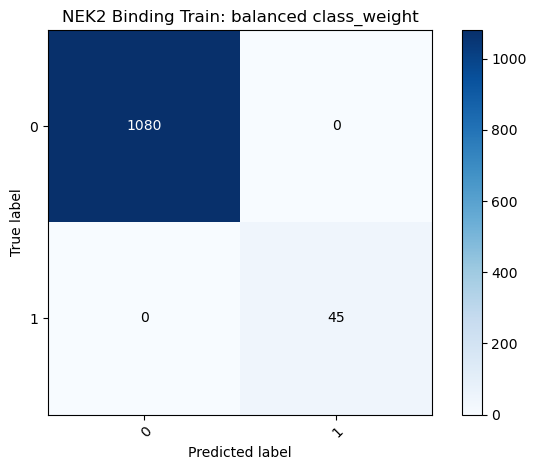

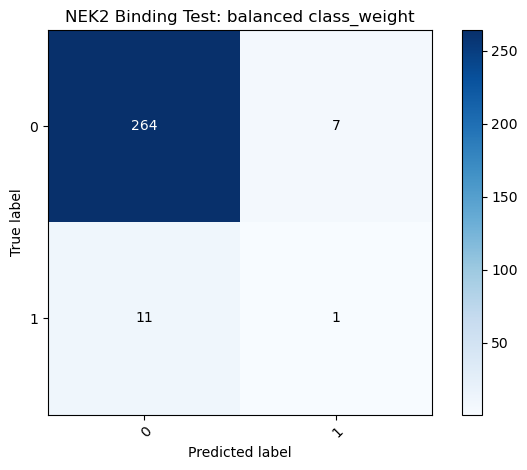

In [27]:
result2 = rf_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {}, 'Binding')


In [ ]:
result2_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced class_weight', {'bootstrap':True, 'class_weight':'balanced'}, 
                                param_grid, 'Binding', 'NEK2bind_gridsearch_classweightbal_best', verbose_val=2)

In [ ]:
best_params2 = result2_best['best_model'].get_params()
    for param, value in best_params2.items():
        print(f"{param}: {value}")
    train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(result2_best['best_model'], train_x, train_y, test_x, test_y)
    classes = ['0','1']
    plot_confusion_matrix(train_y, train_pred, classes, title=f"Best NEK2 Binding Train: balanced class_weight")
    plot_confusion_matrix(test_y, test_pred, classes, title=f"Best NEK2 Binding Test: balanced class_weight")
    pklfile = 'NEK2bind_gridsearch_classweightbal_best.pkl'
    with open(pklfile, 'wb') as f:
        pickle.dump(result2_best['best_model'], f)

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


train accuracy: 0.7333333333333333
test accuracy: 0.7314487632508834


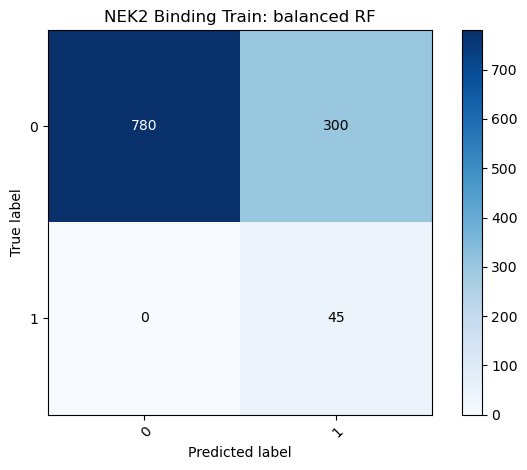

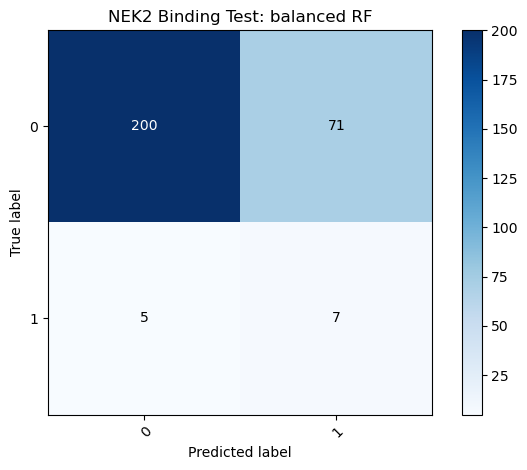

In [28]:
result3 = rf_models(train_x, train_y, test_x, test_y, 'balanced RF', {}, 'Binding')

In [17]:
result3_best = find_best_models(train_x, train_y, test_x, test_y, 'balanced RF', {}, 
                                param_grid, 'Binding', 'NEK2bind_gridsearch_BRF_best', 2)

TypeError: find_best_models() got multiple values for argument 'verbose_val'

In [ ]:
best_params3 = result3_best['best_model'].get_params()
    for param, value in best_params3.items():
        print(f"{param}: {value}")
    train_pred, test_pred, train_acc, test_acc, train_prob, test_prob = rf_results(result3_best['best_model'], train_x, train_y, test_x, test_y)
    classes = ['0','1']
    plot_confusion_matrix(train_y, train_pred, classes, title=f"Best NEK2 Binding Train: Balanced RF")
    plot_confusion_matrix(test_y, test_pred, classes, title=f"Best NEK2 Binding Test: Balanced RF")
    pklfile = 'NEK2bind_gridsearch_BRF_best.pkl'
    with open(pklfile, 'wb') as f:
        pickle.dump(result2_best['best_model'], f)